In [141]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
import cv2
from PIL import Image
import math
from scipy.stats import spearmanr

from baseline import MultiMethod

import torch
from torchvision import transforms
import torch.nn as nn
from muenn import MueNN
from utils import InputPadder

In [142]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [143]:
def load_data(cls):

    datas_multimodel = glob.glob(os.path.join(data_path_multimodel, cls+'*.npy'))
    datas_multitransform = glob.glob(os.path.join(data_path_multitransform, cls+'*.npy'))
    datas_truth = glob.glob(os.path.join(data_path_truth, cls+'*.npy'))
    # datas_ur = glob.glob(os.path.join(data_path_ur, 'S*.npy'))
    datas_ur_img_1 = glob.glob(os.path.join(data_path_ur, cls+'*img1.tif'))
    datas_ur_img_2 = glob.glob(os.path.join(data_path_ur, cls+'*img2.tif'))
    datas_un = glob.glob(os.path.join(data_path_un, cls+'*.npy'))

    datas_multimodel = sorted(datas_multimodel)
    datas_multitransform = sorted(datas_multitransform)
    datas_truth = sorted(datas_truth)
    datas_un = sorted(datas_un)

    # datas_ur = sorted(datas_ur)
    datas_ur_img_1 = sorted(datas_ur_img_1)
    datas_ur_img_2 = sorted(datas_ur_img_2)
    assert len(datas_multimodel) == len(datas_ur_img_1) == len(datas_ur_img_2)
    
    return datas_multimodel, datas_multitransform, datas_truth, datas_un

def compute_sigma(mms, mts, uns, mm, mt, mue):
    idx_random = random.randint(0, len(uns))
    u_res = np.abs(np.load(uns[idx_random])[-2] - np.load(uns[idx_random])[2])
    v_res = np.abs(np.load(uns[idx_random])[-1] - np.load(uns[idx_random])[3])
    u_mm, v_mm = mm.uncertainty(np.load(mms[idx_random]))
    u_mt, v_mt = mt.uncertainty(np.load(mts[idx_random]))
    data_mue = np.load(uns[idx_random])[:4]
    data_mue = torch.from_numpy(data_mue).to(DEVICE)
    u_mue, v_mue = mue.get_sigma(data_mue)
    
    return np.stack((u_mm, u_mt, u_mue, u_res, v_mm, v_mt, v_mue, v_res), 0)

def get_sigma():
    
    cls = ['backstep', 'cylinder', 'JHTDB_channel', 'JHTDB_isotropic1024_hd', 'JHTDB_mhd1024_hd', 'SQG']
    model_path = '/home/panding/code/UR/unet-model/best-1.pt'
    my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mue = MueNN(model_path, my_device)
    mm = MultiMethod(0)
    mt = MultiMethod(1)
    cls_random = random.randint(0, len(cls)-1)
    print(cls[cls_random])
    mms, mts, truths, uns = load_data(cls[cls_random])
    result = compute_sigma(mms, mts, uns, mm, mt, mue)
    
    return result

In [144]:
data_path_multimodel = '/home/panding/code/UR/piv-data/unflownet-mm'
data_path_multitransform = '/home/panding/code/UR/piv-data/unflownet-mt'
data_path_truth = '/home/panding/code/UR/piv-data/truth'
data_path_un = '/home/panding/code/UR/piv-data/ur-un'
data_path_ur = '/home/panding/code/UR/piv-data/raft-test'

res = get_sigma()

cylinder


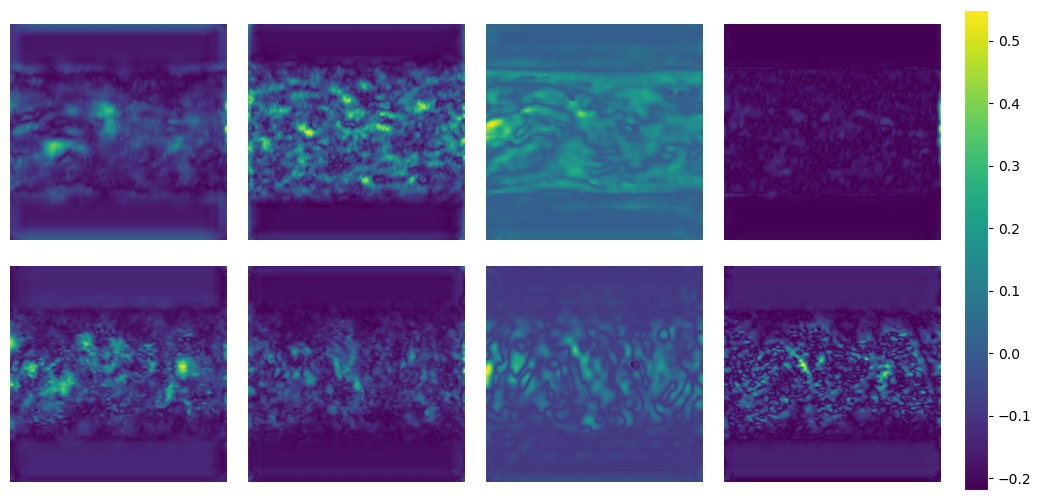

In [145]:
# 定义子图的行数和列数
num_rows = 2
num_cols = 4

# 创建一个新的图像，并设置子图布局
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6), facecolor='white')

# 将每个图像显示在对应的子图中
for i in range(num_rows):
    for j in range(num_cols):
        # 获取当前子图的坐标
        ax = axes[i, j]
        # 获取当前图像的索引
        img_index = i * num_cols + j
        # 显示图像
        im = ax.imshow(res[img_index])
        # 隐藏坐标轴
        ax.axis('off')
        
        if img_index == 2:
            # 将 colorbar 与第三个图像关联
            cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # 调整 colorbar 的位置和尺寸
            cbar = fig.colorbar(im, cax=cax)

# 调整子图之间的间距，并设置填充为白色
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# 设置 colorbar 的字体颜色为黑色
cbar.ax.tick_params(colors='black')

# 显示图像
plt.show()